# Statoil/C-CORE Iceberg Classifier Challenge

##### Reference: https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d
##### Author of kernel: https://www.kaggle.com/devm2024

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [3]:
train = pd.read_json('./Dataset/train.json')

In [4]:
test = pd.read_json('./Dataset/test.json')

In [5]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [6]:
print(len(train['band_1'][0]))

5625


In [7]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_2']])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis], ((X_band_1 + X_band_2) / 2)[:, :, :, np.newaxis]], axis=-1)

In [8]:
X_band_1.shape

(1604, 75, 75)

In [9]:
X_train.shape

(1604, 75, 75, 3)

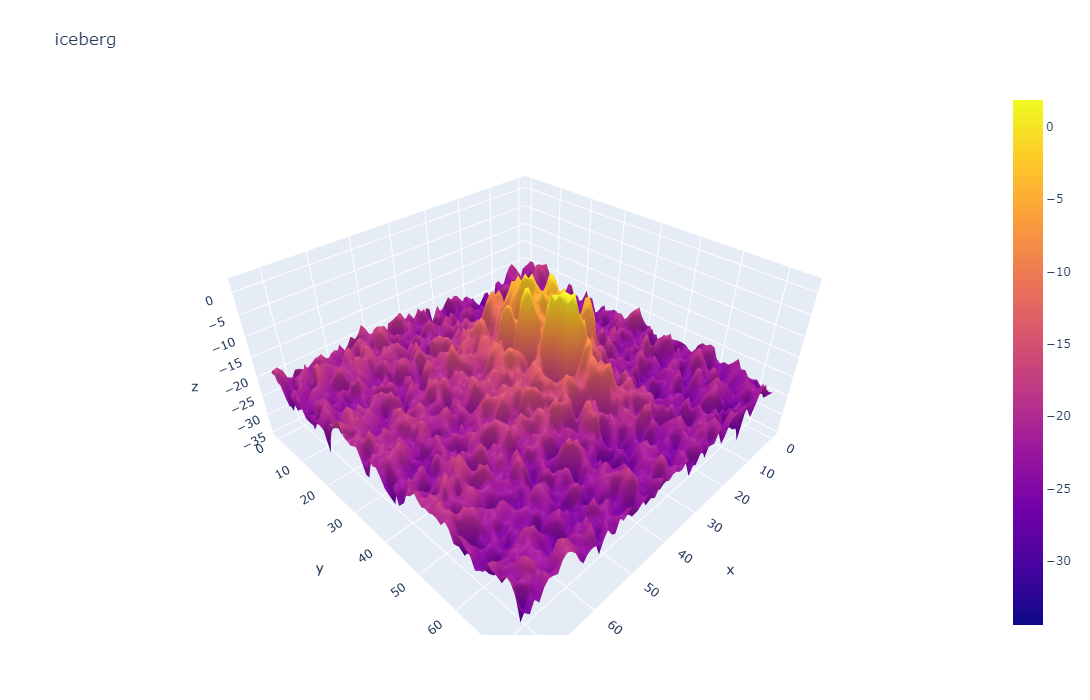

In [10]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):
    data = [go.Surface(z=c)]
    layout = go.Layout(title = name, autosize=False, width=700, height=700, margin=dict(l=65,r=50,b=65,t=90))
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:],'iceberg')

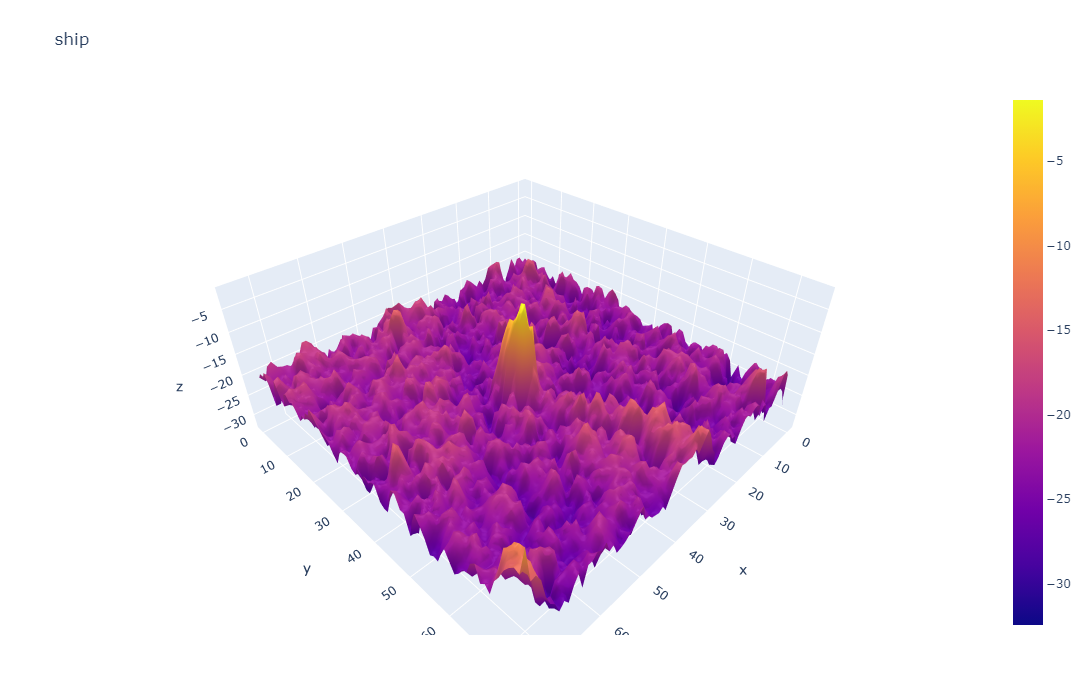

In [11]:
plotmy3d(X_band_1[14,:,:], 'ship')

In [12]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.


In [13]:
def getModel():
    # Building the model
    gmodel = Sequential()
    # Conv layer 1
    gmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape = (75,75,3)))
    gmodel.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    gmodel.add(Dropout(0.2))
    
    # Conv layer 2
    gmodel.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    gmodel.add(Dropout(0.2))
    
    # Conv layer 3
    gmodel.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    gmodel.add(Dropout(0.2))
    
    # Conv layer 4
    
    gmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    gmodel.add(Dropout(0.2))
    
    # Flatten layer
    gmodel.add(Flatten())
    
    # Dense layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))
    
    # Dense layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))
    
    # Sigmoid layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))
    
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2= 0.999, epsilon=1e-08,decay=0.0)
    gmodel.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    gmodel.summary()
    return gmodel

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode='min')
    msave = ModelCheckpoint(filepath, save_best_only = True)
    return [es, msave]
file_path = 'model_weights.hdf5'
callbacks = get_callbacks(filepath = file_path, patience=5)

In [14]:
target_train = train['is_iceberg']
train.drop('is_iceberg', axis=1)
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [15]:
import os
gmodel = getModel()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [16]:
gmodel.fit(X_train_cv, y_train_cv, batch_size=24, epochs=50, verbose=1, validation_data = (X_valid, y_valid), callbacks=callbacks)

Train on 1203 samples, validate on 401 samples
Epoch 1/50
1203/1203 [==============================] - 6s 5ms/step - loss: 0.9633 - accuracy: 0.5254 - val_loss: 0.5798 - val_accuracy: 0.6683
Epoch 2/50
1203/1203 [==============================] - 6s 5ms/step - loss: 0.5565 - accuracy: 0.6725 - val_loss: 0.5538 - val_accuracy: 0.6958
Epoch 3/50
1203/1203 [==============================] - 6s 5ms/step - loss: 0.5262 - accuracy: 0.6999 - val_loss: 0.5254 - val_accuracy: 0.7431
Epoch 4/50
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4933 - accuracy: 0.7406 - val_loss: 0.4497 - val_accuracy: 0.7855
Epoch 5/50
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4586 - accuracy: 0.7722 - val_loss: 0.4537 - val_accuracy: 0.7930
Epoch 6/50
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4171 - accuracy: 0.8138 - val_loss: 0.4045 - val_accuracy: 0.8180
Epoch 7/50
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4090 - accu

In [20]:
gmodel.load_weights(file_path)
score = gmodel.evaluate(X_valid,y_valid,verbose=1)
print('Test loss:',score[0])
print('Test accuracy', score[1])

401/401 [==============================] - 0s 898us/step
Test loss: 0.2688298102774822
Test accuracy 0.8728179335594177


In [21]:
X_band_test_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test['band_1']])
X_band_test_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test['band_2']])
X_test = np.concatenate([X_band_test_1[: ,:,:,np.newaxis], X_band_test_2[:,:,:,np.newaxis],((X_band_test_1+X_band_test_2)/2)[:,:,:,np.newaxis]], axis=-1)
predicted_test = gmodel.predict_proba(X_test)

In [22]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['is_iceberg'] = predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)